In [1]:
#PARAMS
OUTPUT_SENTENCE_LENGTH = 200
EMBEDDING_DIMENSION = 300
ALPHA = 0
BATCH_SIZE = 512

#Installing the Libraries

In [ ]:
!pip install transformers
!pip install spacy
!pip install tensorflow

!pip install datasets

!spacy download en_core_web_sm

#Importing and mounting the drive

In [3]:
import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from datasets import load_from_disk, Dataset
import tensorflow.keras as keras

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the dataset

In [4]:
sst2 = load_from_disk("/content/drive/MyDrive/CS685/project/datasets/SST2")

#Creating Embeddings and Padded sequences of the data

In [5]:
sentences = sst2['train']['sentence']
combined_logits = sst2['train']['combined_logits']
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=OUTPUT_SENTENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(sentences).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
import os
path_to_glove_file = "/content/drive/MyDrive/CS685/project/glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) + 2
embedding_dim = EMBEDDING_DIMENSION
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
padded_sequences = vectorizer(np.array([[s] for s in sentences])).numpy()

Found 400000 word vectors.
Converted 13290 words (1416 misses)


In [6]:
from tqdm.notebook import tqdm

#Custom Loss and Custom accuracy metric Iterating on alpha to find the best alpha

In [7]:
# alpha = ALPHA
class TotalLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
    teacher_logits = teacher_logits[:, 0]
    loss_wrt_teacher = tf.math.reduce_mean(tf.square(teacher_logits - y_pred))
    loss_wrt_true = tf.math.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_labels, logits=y_pred))
    return alpha*loss_wrt_true+(1-alpha)*loss_wrt_teacher

class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
      true_labels, teacher_logits= tf.split(y_true, num_or_size_splits=2, axis=1)
      y_pred = tf.argmax(y_pred, axis=-1)
      y_true = tf.argmax(true_labels, axis=-1)
      y_true = tf.squeeze(y_true)
      cur_correct = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
      cur_smaples = tf.cast(tf.size(y_pred), tf.float32)
      
      self.total_correct.assign_add(cur_correct)
      self.total_samples.assign_add(cur_smaples)
    
    def result(self):
        return self.total_correct / self.total_samples
    
    def reset_state(self):
        self.total_correct.assign(0.0)
        self.total_samples.assign(0.0)

for alpha in tqdm([0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.5, 0.0]):
  print(alpha)
  try:
    del model
  except Exception as e:
    print('No Model')

  model = Sequential()

  model.add(Embedding(
      num_tokens,
      embedding_dim,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix),
      trainable=False,
  ))
  model.add(Bidirectional(LSTM(300, return_sequences=False, input_shape=(None, 1))))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
  model.add(Dropout(0.2)) # Avoid Overfitting
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2))

  optimizer = Adam()
  # optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)

  model.compile(
      loss=TotalLoss(), 
      optimizer=optimizer, 
      metrics=[CustomAccuracy()],
      run_eagerly = True
  )

  model.summary()

  history = model.fit(
      padded_sequences, 
      np.array(combined_logits), 
      epochs=5,
      verbose=1,
      batch_size=BATCH_SIZE,
      validation_split=0.01
  )
  print('alpha', alpha)
  print(history.history['val_accuracy'])
  print(history.history['accuracy'])

  0%|          | 0/10 [00:00<?, ?it/s]

0.45
No Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4412400   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 400)               240400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 802       
                                          

780/780 [==============================] - 118s 148ms/step - loss: 0.8631 - accuracy: 0.8458 - val_loss: 0.6321 - val_accuracy: 0.8727
Epoch 2/5
780/780 [==============================] - 115s 148ms/step - loss: 0.7669 - accuracy: 0.8636 - val_loss: 0.5412 - val_accuracy: 0.8879
Epoch 3/5
780/780 [==============================] - 115s 148ms/step - loss: 0.5604 - accuracy: 0.8901 - val_loss: 0.4510 - val_accuracy: 0.9030
Epoch 4/5
780/780 [==============================] - 115s 148ms/step - loss: 0.6147 - accuracy: 0.8875 - val_loss: 0.4061 - val_accuracy: 0.9082
Epoch 5/5
780/780 [==============================] - 116s 148ms/step - loss: 0.4341 - accuracy: 0.9095 - val_loss: 0.3783 - val_accuracy: 0.9127
alpha 0.45
[0.8727362751960754, 0.8878690004348755, 0.9030017256736755, 0.908211350440979, 0.9126767516136169]
0.4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Em

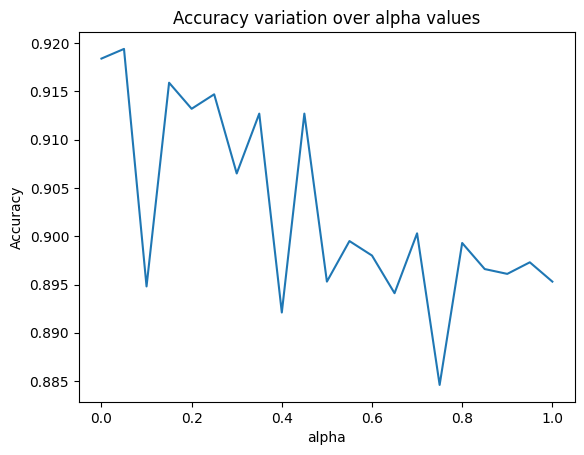

In [9]:
import matplotlib.pyplot as plt
x = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
y = [0.9184, 0.9194, 0.8948, 0.9159, 0.9132, 0.9147, 0.9065, 0.9127, 0.8921, 0.9127, 0.8953, 0.8995, 0.898, 0.8941, 0.9003, 0.8846, 0.8993, 0.8966, 0.8961, 0.8973, 0.8953]

fig = plt.plot(x, y)
title = plt.title("Accuracy variation over alpha values")
xlabel = plt.xlabel("alpha")
ylabel = plt.ylabel("Accuracy")

#Training the model with best alpha found

In [11]:
alpha = 0.0 # Best Value

try:
    del model
except Exception as e:
  print('No Model')

model = Sequential()

model.add(Embedding(
  num_tokens,
  embedding_dim,
  embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  trainable=False,
))
model.add(Bidirectional(LSTM(300, return_sequences=False, input_shape=(None, 1))))  #Check what does input shape mean #Remove this 50 X 300(glove) & 50X64 
model.add(Dropout(0.2)) # Avoid Overfitting
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))

optimizer = Adam()
# optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07)

model.compile(
  loss=TotalLoss(), 
  optimizer=optimizer, 
  metrics=[CustomAccuracy()],
  run_eagerly = True
)

model.summary()

history = model.fit(
  padded_sequences, 
  np.array(combined_logits), 
  epochs=15,
  verbose=1,
  batch_size=BATCH_SIZE,
  validation_split=0.01
)

print(history.history['val_accuracy'])
print(history.history['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 300)         4412400   
                                                                 
 bidirectional_10 (Bidirecti  (None, 600)              1442400   
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 600)               0         
                                                                 
 dense_20 (Dense)            (None, 400)               240400    
                                                                 
 dropout_21 (Dropout)        (None, 400)               0         
                                                                 
 dense_21 (Dense)            (None, 2)                 802       
                                                     

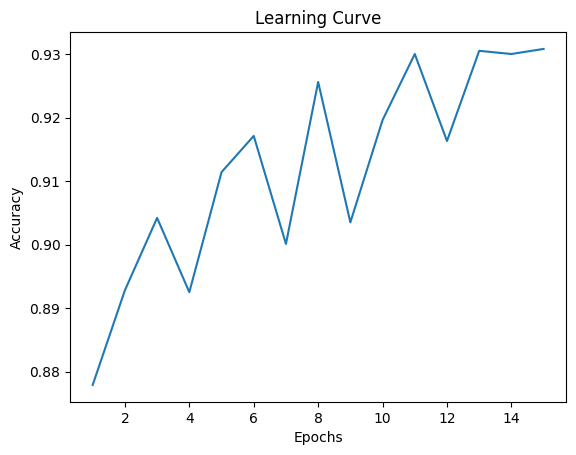

In [22]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 16, 1)]
y = [0.8779, 0.8928, 0.9042, 0.8925, 0.9114, 0.9171, 0.9001, 0.9256, 0.9035, 0.9196, 0.9300, 0.9163, 0.9305, 0.9300, 0.9308]

fig = plt.plot(x, y)
title = plt.title("Learning Curve")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

#Compute the Metrics

In [23]:
test_padded_sequences = vectorizer(np.array([[s] for s in sst2['validation']['sentence']])).numpy()
true_lables = np.array(sst2['validation']['label'])

predictions = model.predict(test_padded_sequences)

class_labels = np.argmax(predictions, axis=-1)

#Code for f1 score and confusion matrix

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

cm = confusion_matrix(true_lables, class_labels)
f1 = f1_score(true_lables, class_labels)
accuracy = accuracy_score(true_lables, class_labels)

print("Confusion Matrix: \n", cm)
print("F1 Score:", f1)
print('Accuracy:', accuracy)

28/28 [==============================] - 1s 22ms/step
Confusion Matrix: 
 [[353  75]
 [ 68 376]]
F1 Score: 0.8402234636871508
Accuracy: 0.8360091743119266


In [25]:
flag = np.array(class_labels == true_lables)
missed_values = []
identified_values = []
for i, f in enumerate(flag):
  if f:
    identified_values.append((sst2['validation'][i]['sentence'], sst2['validation'][i]['label']))

for i, f in enumerate(flag):
  if not f:
    missed_values.append((sst2['validation'][i]['sentence'], sst2['validation'][i]['label']))

#Failed Cases

In [26]:
missed_values

[("or doing last year 's taxes with your ex-wife . ", 0),
 ("you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ",
  1),
 ("we root for ( clara and paul ) , even like them , though perhaps it 's an emotion closer to pity . ",
  1),
 ('pumpkin takes an admirable look at the hypocrisy of political correctness , but it does so with such an uneven tone that you never know when humor ends and tragedy begins . ',
  0),
 ("it 's a cookie-cutter movie , a cut-and-paste job . ", 0),
 ("if the movie succeeds in instilling a wary sense of ` there but for the grace of god , ' it is far too self-conscious to draw you deeply into its world . ",
  0),
 ('the weight of the piece , the unerring professionalism of the chilly production , and the fascination embedded in the lurid topic prove recommendation enough . ',
  1),
 ("( w ) hile long on amiable monkeys and worthy environmentalism , jane goodall 's wild chimpanzees is short on the thrills the ove